In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.8 MB/s eta 0:00:00


In [ ]:
import argparse
import gymnasium as gym
import numpy as np
from itertools import count
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import pandas as pd



gamma=0.99
seed=543

log_interval=10



# Step 1: Define hook functions and data structures
activation_data = {
    "pre_activations": {
        "affine1": [],  # Store pre-activations for affine1
        "affine2": []   # Store pre-activations for affine2
    },
    "post_activations": {
        "affine1": [],  # Store post-activations for affine1
        "affine2": []   # Store post-activations for affine2
    }
}



def hook_pre_activation(module, input, output):
    layer_name = module.__class__.__name__
    if module == model_trained.affine1:
        activation_data["pre_activations"]["affine1"].append(input[0].detach().cpu().numpy())
    elif module == model_trained.affine2:
        activation_data["pre_activations"]["affine2"].append(input[0].detach().cpu().numpy())

def hook_post_activation(module, input, output):
    layer_name = module.__class__.__name__
    if module == model_trained.affine1:
        activation_data["post_activations"]["affine1"].append(output.detach().cpu().numpy())
    elif module == model_trained.affine2:
        activation_data["post_activations"]["affine2"].append(output.detach().cpu().numpy())



class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(7, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []
        self.affine1.register_forward_hook(hook_pre_activation)
        self.affine1.register_forward_hook(hook_post_activation)
        self.affine2.register_forward_hook(hook_pre_activation)
        self.affine2.register_forward_hook(hook_post_activation)


    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)





model_trained = Policy()
#optimizer_trained = optim.Adam(model_trained.parameters(), lr=1e-2)
model_untrained = Policy()
optimizer_untrained = optim.Adam(model_untrained.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()




env = gym.make("two-step-task-original-v0", render_mode='human')

In [ ]:
# Load the checkpoint from Google Drive
path = "/content/drive/MyDrive/Models/folder_name/"
file_name_trained="best_checkpoint_atThreshold346.pth"
checkpoint_tarined = torch.load(f"{path}{file_name_trained}", weights_only=False)

# Load the model and optimizer state
optimizer = optim.Adam(model_trained.parameters())  # Recreate the optimizer with the same settings as before
model_trained.load_state_dict(checkpoint_tarined['model_state_dict'])
optimizer.load_state_dict(checkpoint_tarined['optimizer_state_dict'])
model_trained.train()



Policy(
  (affine1): Linear(in_features=7, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (affine2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# Function to test the trained policy
def test_policy(policy, env, num_episodes=100, render=False, nnType = 'Trained',action_given=0):
    # Put the model in evaluation mode
    policy.eval()
    global activation_data  # Use the global activation data

    # Disable gradient calculations during inference
    with torch.no_grad():

        running_reward = 10
        # Step 1: Create an empty DataFrame
        df = pd.DataFrame(columns=['episode', 'trial_num', 'actionInS1', 'stateInS1',
                               'common', 'actionIS2', 'reward', 'stateInS2', 'score',
                               'p_win_state1_action1','p_win_state1_action2',
                               'p_win_state2_action1', 'p_win_state2_action2','stake'])
        for i in range(num_episodes):


            state = env.reset()[0]
            done = False
            score = 0
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            for t in range(1, 10000):
                if render:
                  env.render()

                # Convert state to tensor and send to device
                state_tensor = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)

                # Get action probabilities and hidden state from the policy
                action_probs = policy(state_tensor)

                # Sample action
                action_dist = Categorical(action_probs)
                action = action_dist.sample()

              # the bias won't be used since authentic untrained NN is tested to sum up activities

                if nnType== 'Trained':
                  action_to_use= action.item()
                else:
                  action_to_use= action.item()#action_given
                if t % 2 != 0:
                    df.loc[len(df), ['actionInS1','stateInS1']] = [action_to_use, state]
                else:
                    df.loc[len(df)-1, [ 'stateInS2']] = [state]

                # Take action in the environment
                next_state, reward, done, _, info = env.step(action_to_use)
                score += reward
                if t % 2 ==0:
                    matrix=info["winning_matrix"]
                    matrix= matrix.tolist()
                    df.loc[len(df)-1, ['actionIS2', 'reward', 'score', 'p_win_state1_action1',
                                   'p_win_state1_action2', 'p_win_state2_action1', 'p_win_state2_action2']] = [action_to_use, reward, score,
                                                                                                               matrix[0][0], matrix[0][1],
                                                                                                               matrix[1][0], matrix[1][1]]

                else:
                    df.loc[len(df)-1, ['episode', 'trial_num', 'common', 'stake']] = [i, info["number of trials"], info["common"], info["stake"]]

                # Update state
                state = next_state

                if done:
                    break


            print(f"Episode {i+1} finished with total reward: {score}")
            running_reward = 0.05 * score + (1 - 0.05) * running_reward  # Update running reward



    env.close()

    trained_pre_activation_dfs = save_activations_to_dataframe(activation_data, "pre_activations",nntype=nnType)
    trained_post_activation_dfs = save_activations_to_dataframe(activation_data, "post_activations",nntype=nnType)
    !mv   /content/activ*.csv /content/drive/MyDrive/Models/folder/test_NN_NovelvsNormal/

    return activation_data, df




In [ ]:
actvData, df_trained = test_policy(model_trained, env, num_episodes=100, render=True, nnType = 'Trained',action_given=1)


[1, 0, 0, 1, 2, 1, 0]
Gre   Blu 
      
  Age   

Gre   Blu 
      
  Age   

action 1
obs is [0 1 0 3 4 1 0]
R_1   R_2 
      
  Age   

action 1
obs is [1 0 0 2 1 1 0]
Blu   Gre 
      
  Age   

action 1
obs is [0 1 0 3 4 1 0]
R_1   R_2 
      
  Age   

action 1
obs is [1 0 0 1 2 5 0]


In [ ]:
for layer_name, activations in activation_data["pre_activations"].items():
    print(f"Layer: {layer_name}")
    for i, act in enumerate(activations):
        print(f"  Activation {i} shape: {np.array(act).shape}")


Layer: affine1
  Activation 0 shape: (1, 7)
  Activation 1 shape: (1, 7)
  Activation 2 shape: (1, 7)
  Activation 3 shape: (1, 7)
Layer: affine2
  Activation 0 shape: (1, 128)
  Activation 1 shape: (1, 128)
  Activation 2 shape: (1, 128)
  Activation 3 shape: (1, 128)


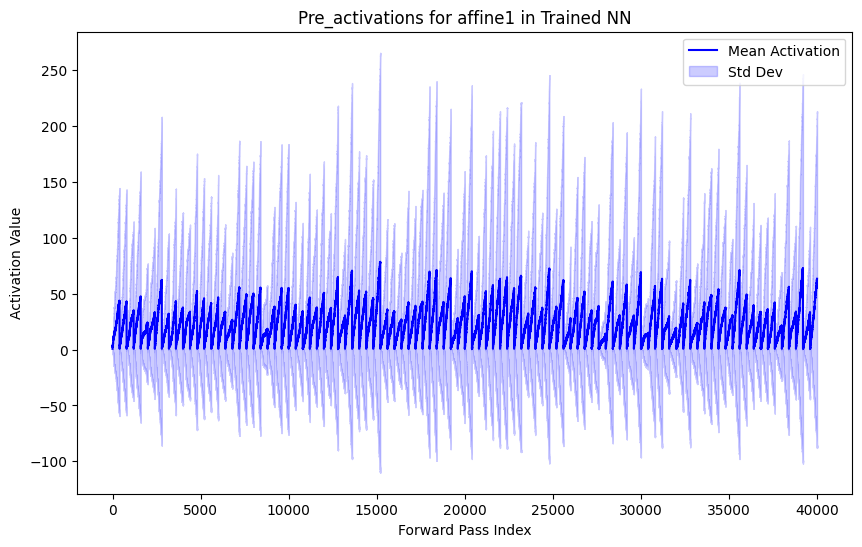

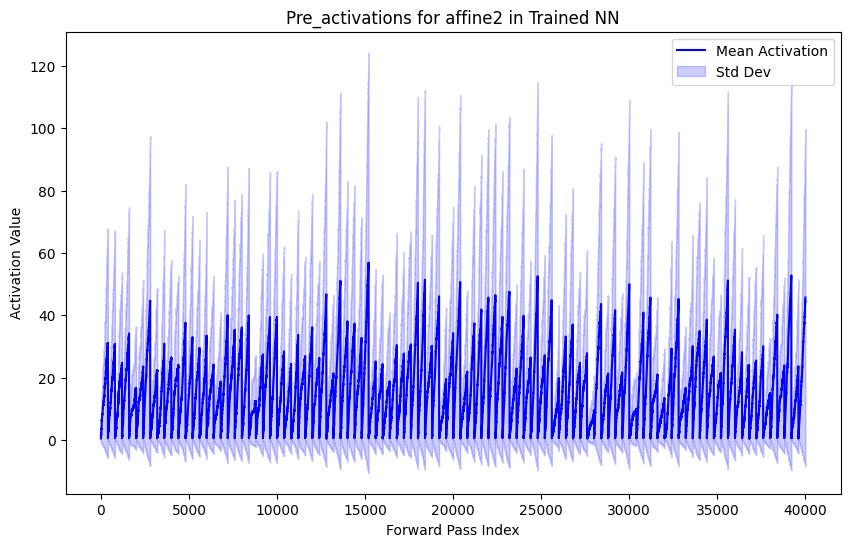

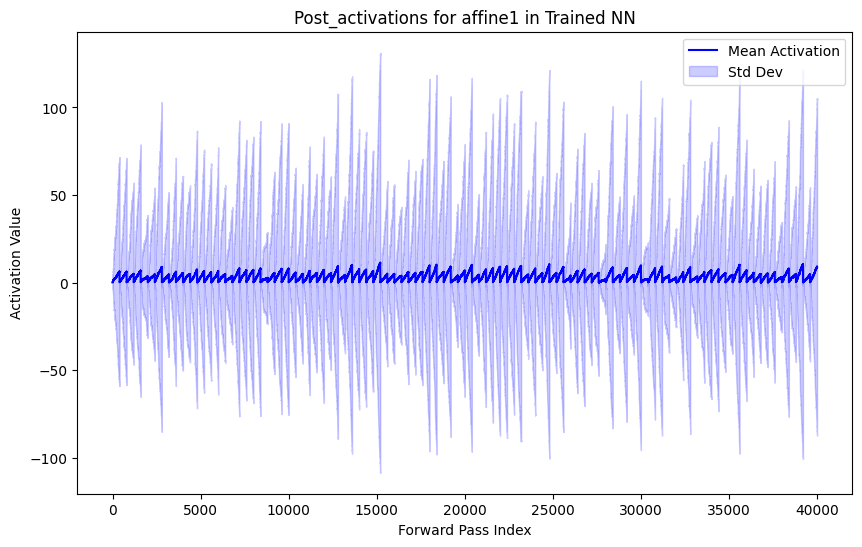

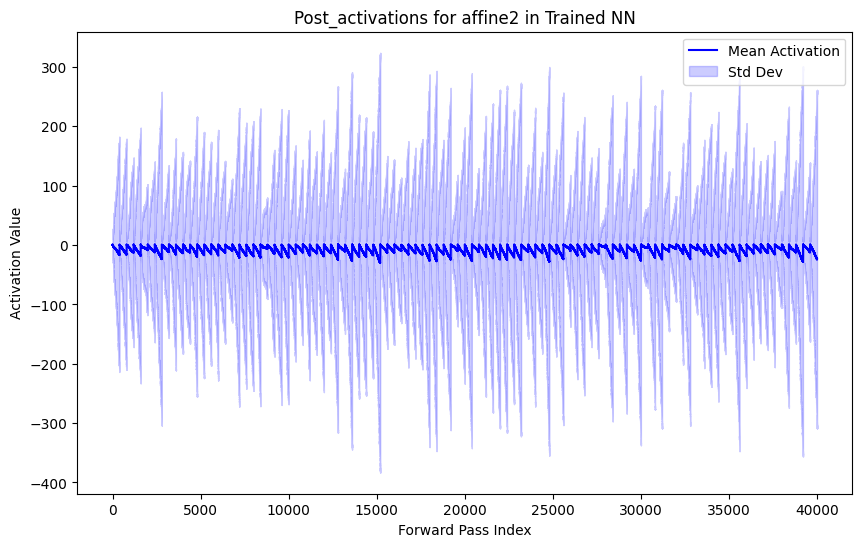

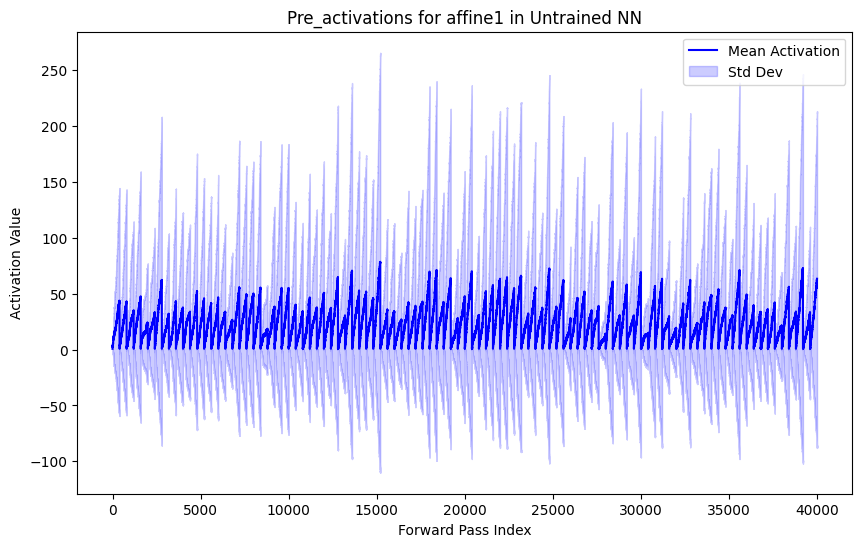

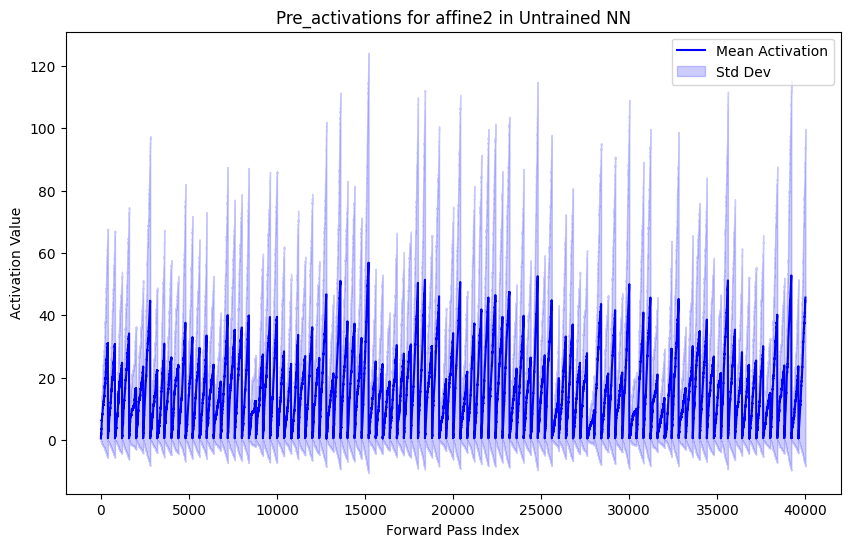

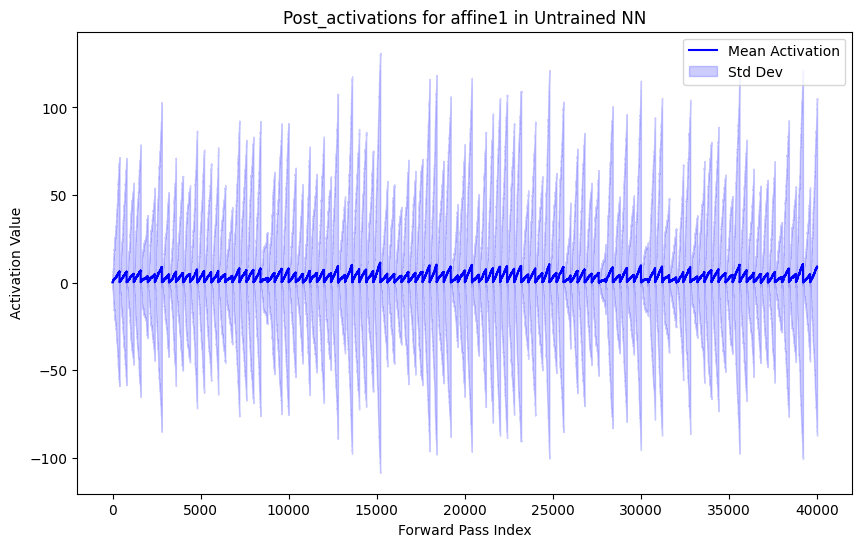

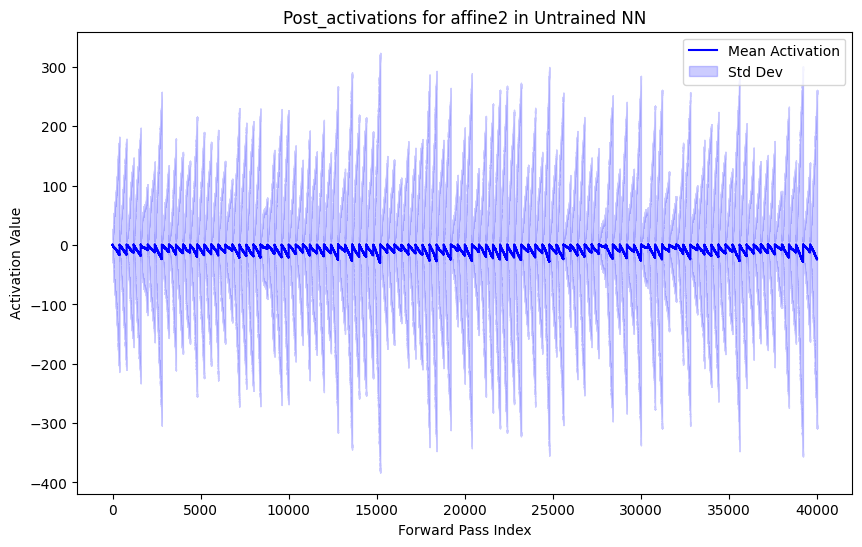

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_activations(activation_data, activation_type="pre_activations", nntype='Trained'):
    for layer_name, activations in activation_data[activation_type].items():
        # Flatten or reduce activations to 2D (num_passes, num_features)
        activations_np = np.array(activations)

        # If activations are multi-dimensional, reduce them to (num_passes, num_units)
        if activations_np.ndim > 2:
            # Flatten all activations across dimensions except the first (num_passes)
            activations_np = activations_np.reshape(activations_np.shape[0], -1)

        # Compute mean and standard deviation across units (axis=1)
        mean_activations = activations_np.mean(axis=1)  # Mean across units
        std_activations = activations_np.std(axis=1)    # Std across units

        # Plot the mean activations with shaded region for std dev
        plt.figure(figsize=(10, 6))
        plt.title(f"{activation_type.capitalize()} for {layer_name} in {nntype} NN")
        plt.plot(mean_activations, label="Mean Activation", color="blue")
        plt.fill_between(
            range(len(mean_activations)),
            mean_activations - std_activations,
            mean_activations + std_activations,
            color="blue",
            alpha=0.2,
            label="Std Dev"
        )
        plt.xlabel("Forward Pass Index")
        plt.ylabel("Activation Value")
        plt.legend()
        plt.show()

# Example: Plot pre-activations and post-activations
plot_activations(activ_trained, "pre_activations", nntype='Trained')
plot_activations(activ_trained, "post_activations", nntype='Trained')
plot_activations(activ_untrained, "pre_activations", nntype='Untrained')
plot_activations(activ_untrained, "post_activations", nntype='Untrained')


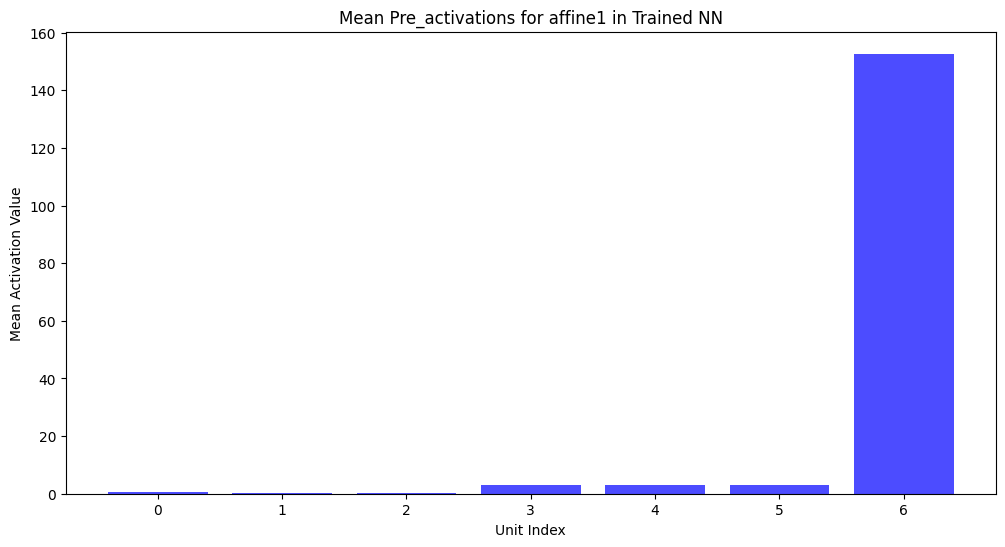

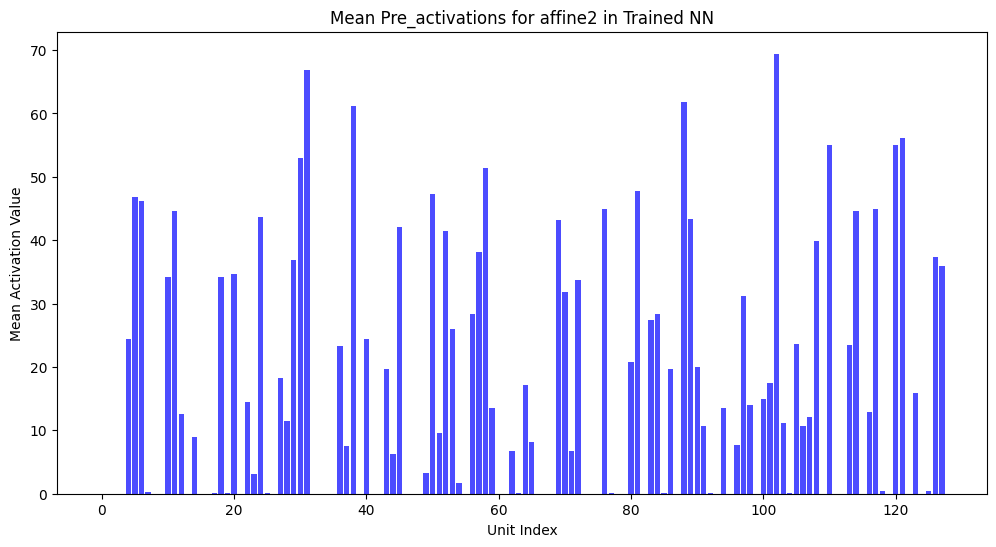

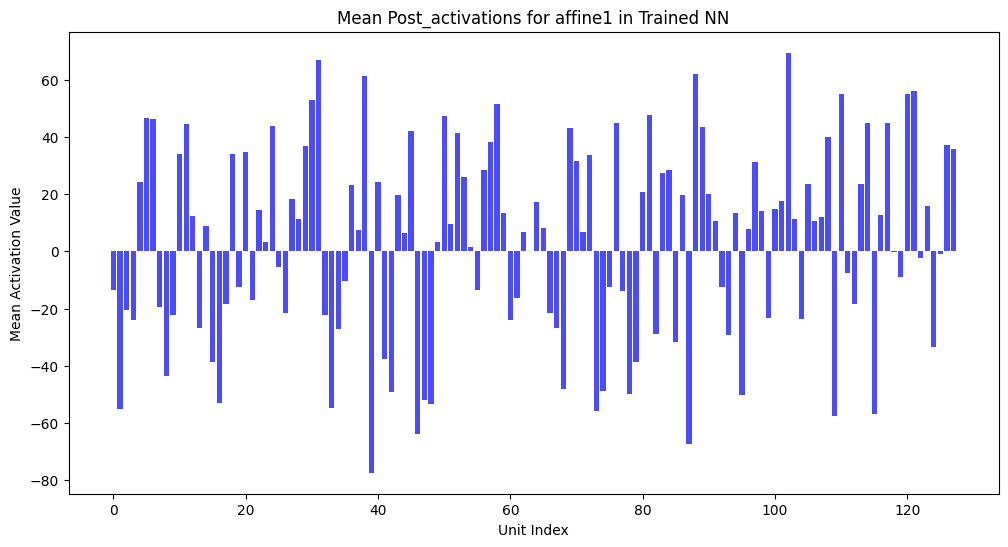

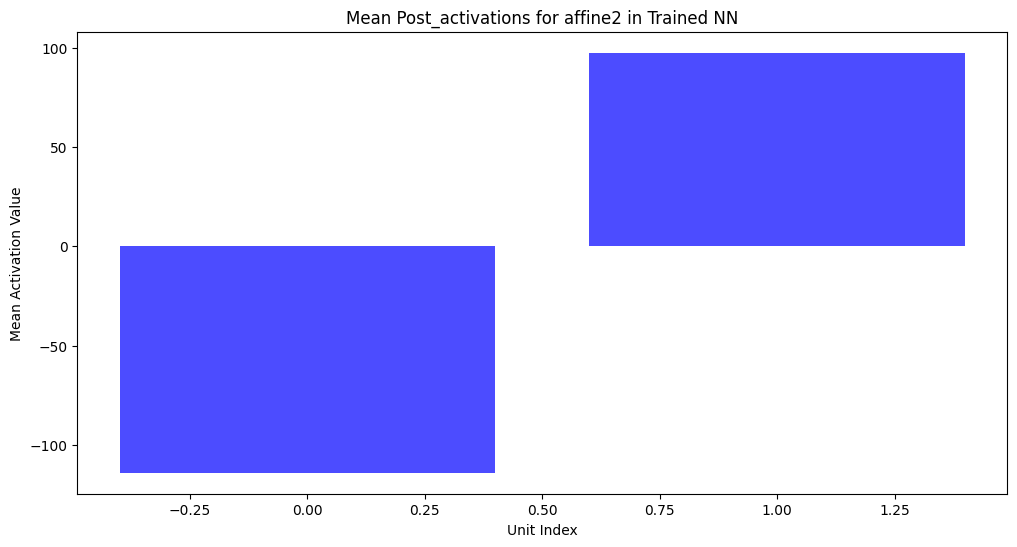

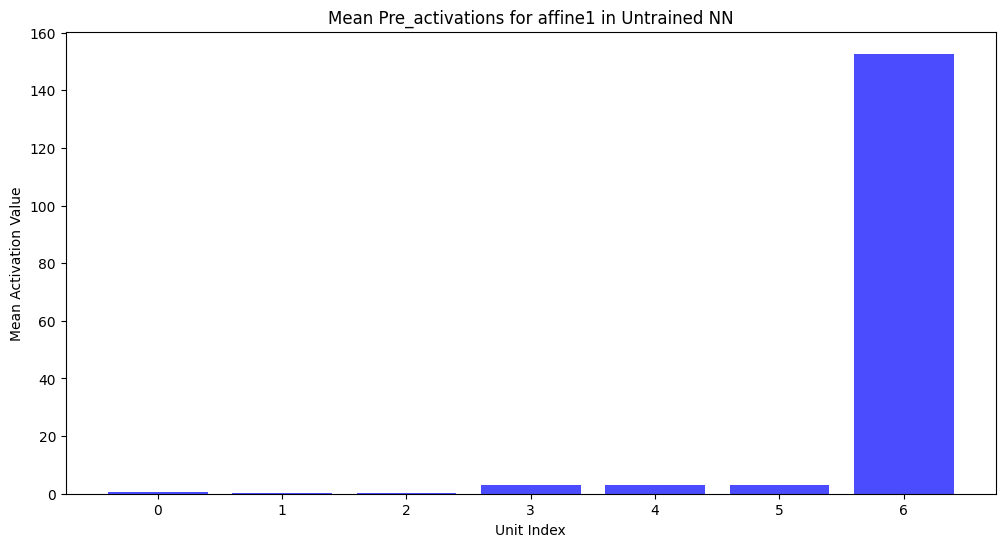

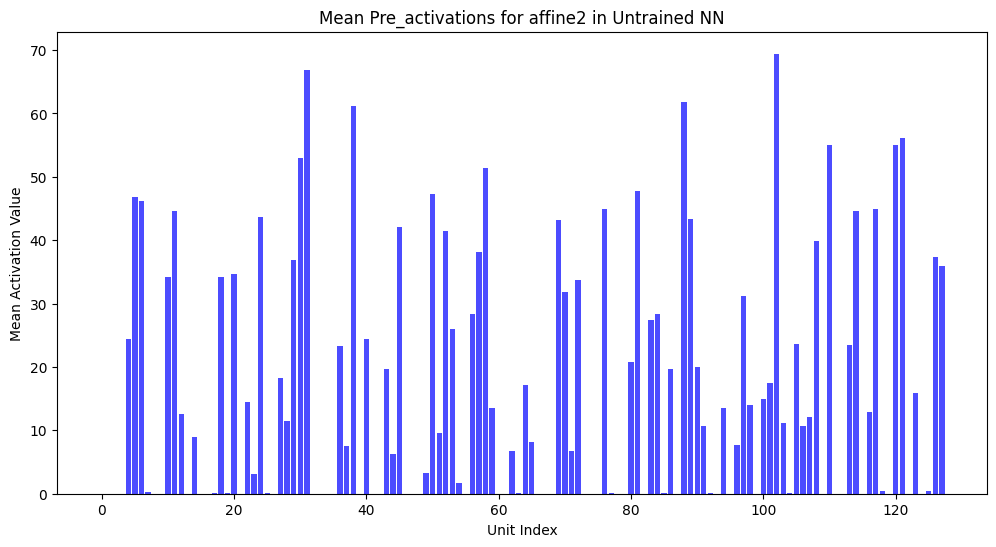

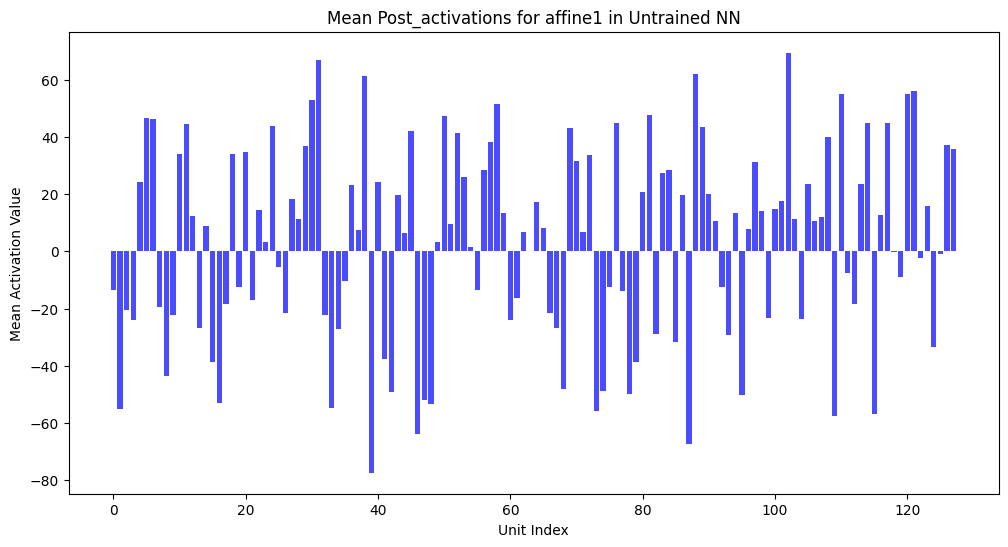

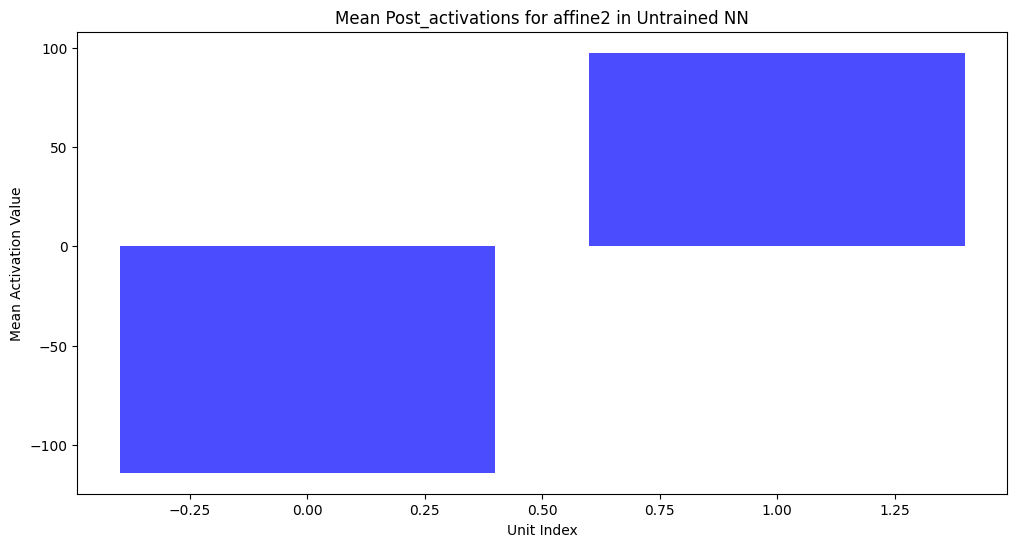

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_activation_bars(activation_data, activation_type="pre_activations", nntype='Trained'):
    for layer_name, activations in activation_data[activation_type].items():
        # Convert activations to numpy array
        activations_np = np.array(activations)  # Shape: (num_passes, batch_size, num_units)

        # Remove batch dimension by squeezing
        activations_np = activations_np.squeeze(axis=1)  # Shape: (num_passes, num_units)

        # Compute mean activations across forward passes
        mean_activations = activations_np.mean(axis=0)  # Mean across forward passes

        # Bar plot
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(mean_activations)), mean_activations, color="blue", alpha=0.7)
        plt.title(f"Mean {activation_type.capitalize()} for {layer_name} in {nntype} NN")
        plt.xlabel("Unit Index")
        plt.ylabel("Mean Activation Value")
        plt.show()

# Example: Bar plots for pre-activations and post-activations
plot_activation_bars(activ_trained, "pre_activations", nntype='Trained')
plot_activation_bars(activ_trained, "post_activations", nntype='Trained')
plot_activation_bars(activ_untrained, "pre_activations", nntype='Untrained')
plot_activation_bars(activ_untrained, "post_activations", nntype='Untrained')

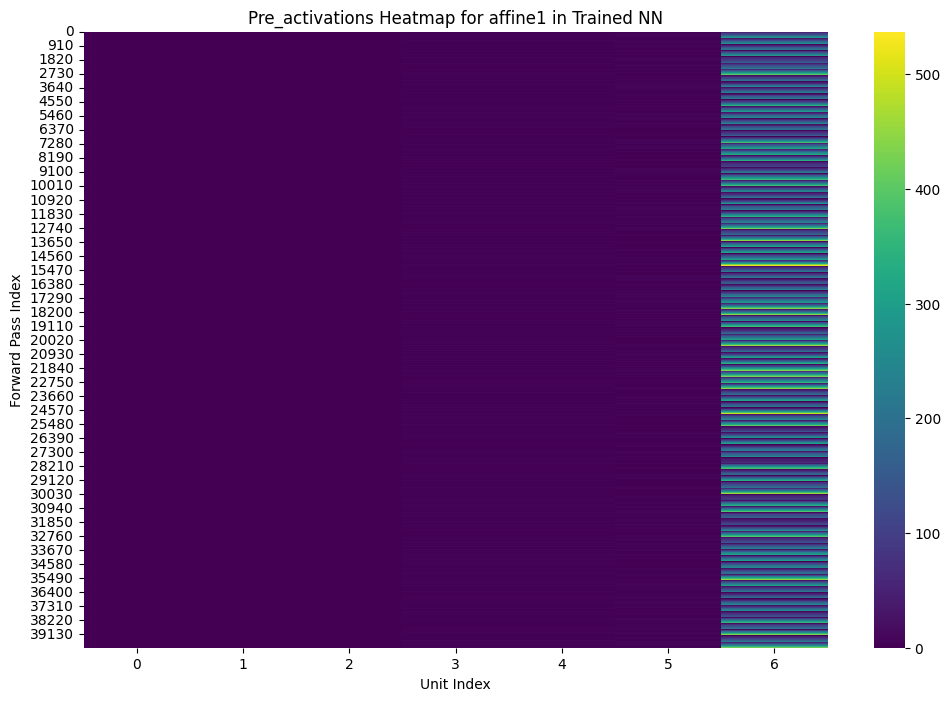

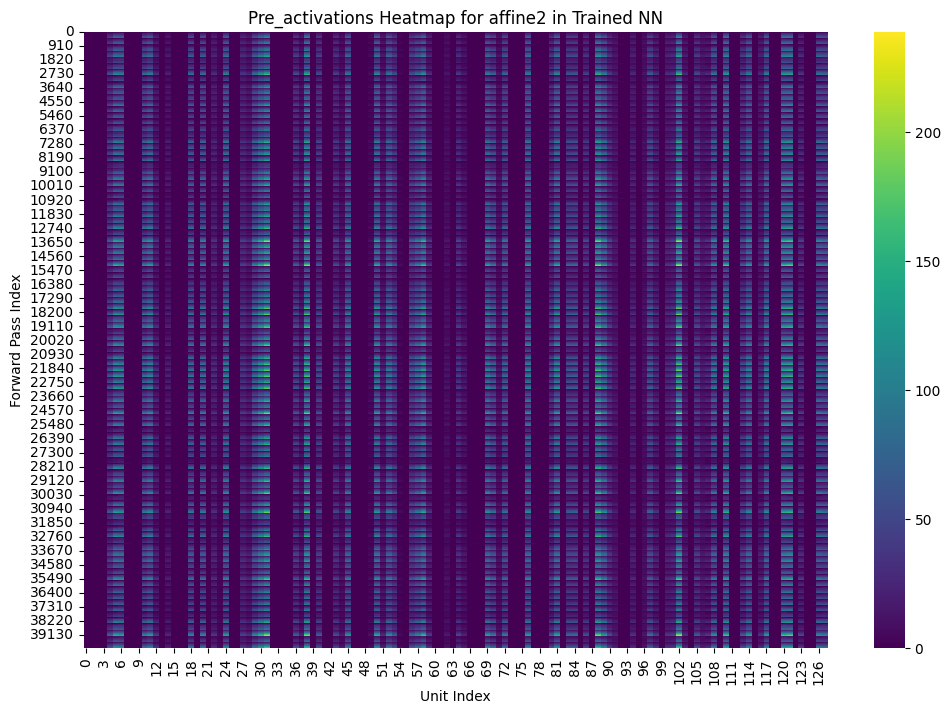

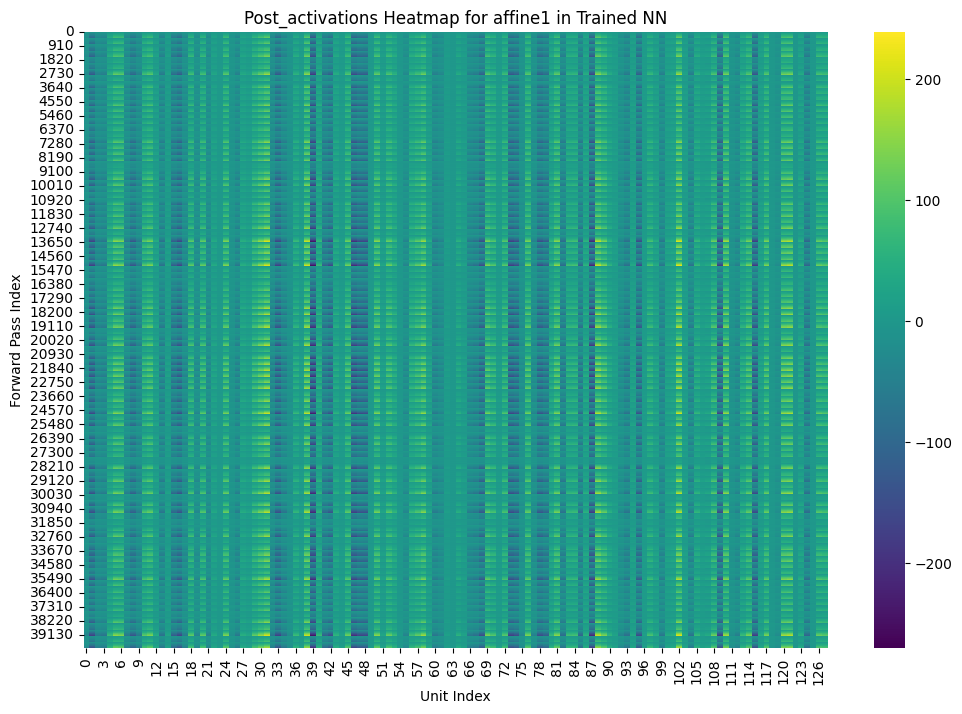

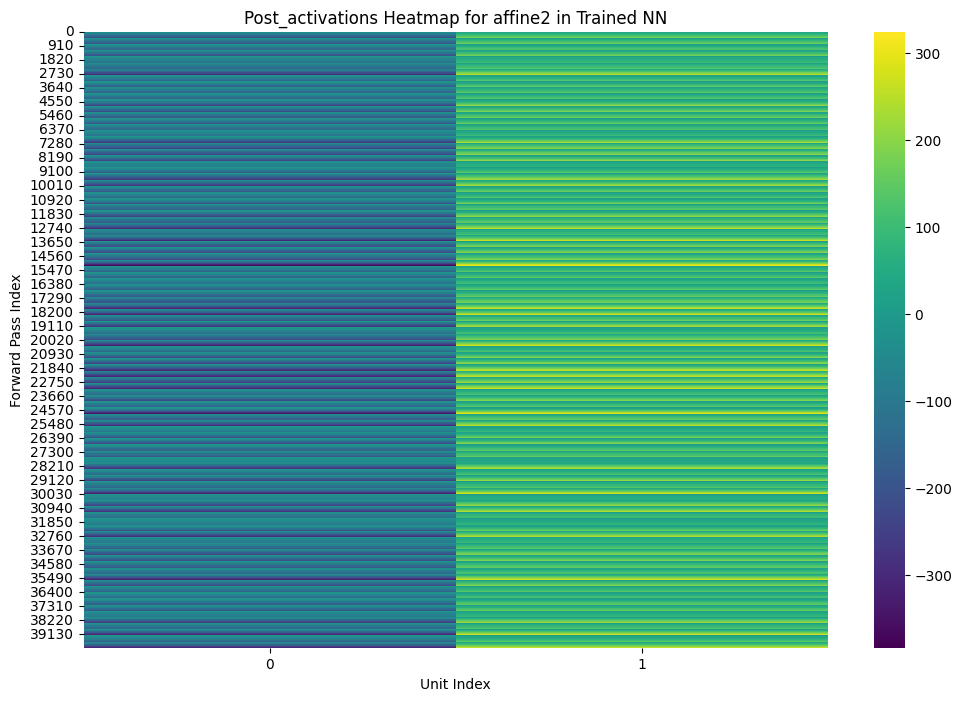

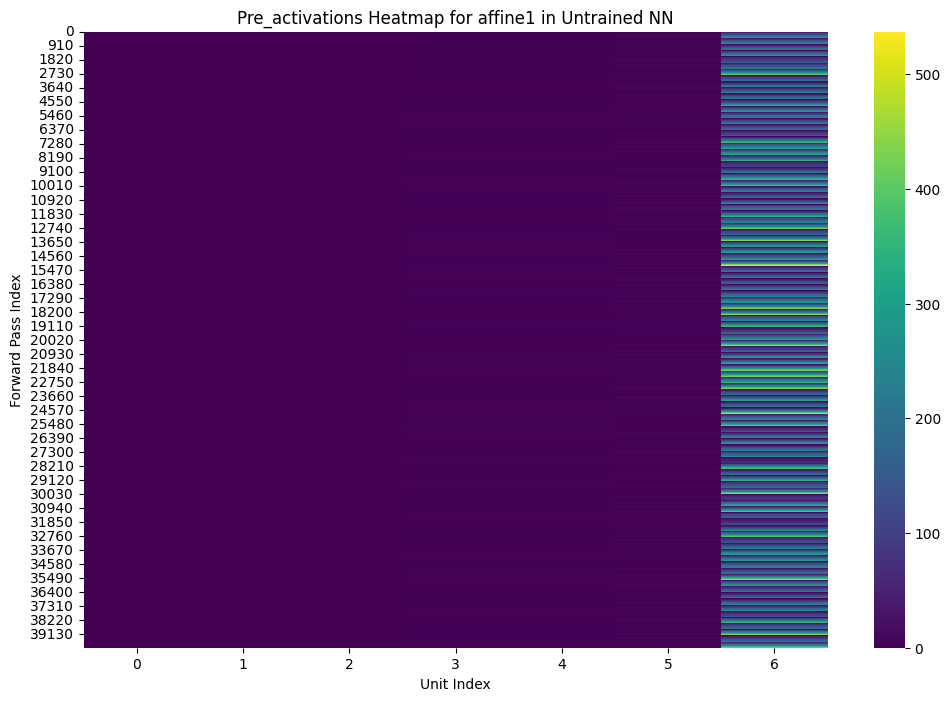

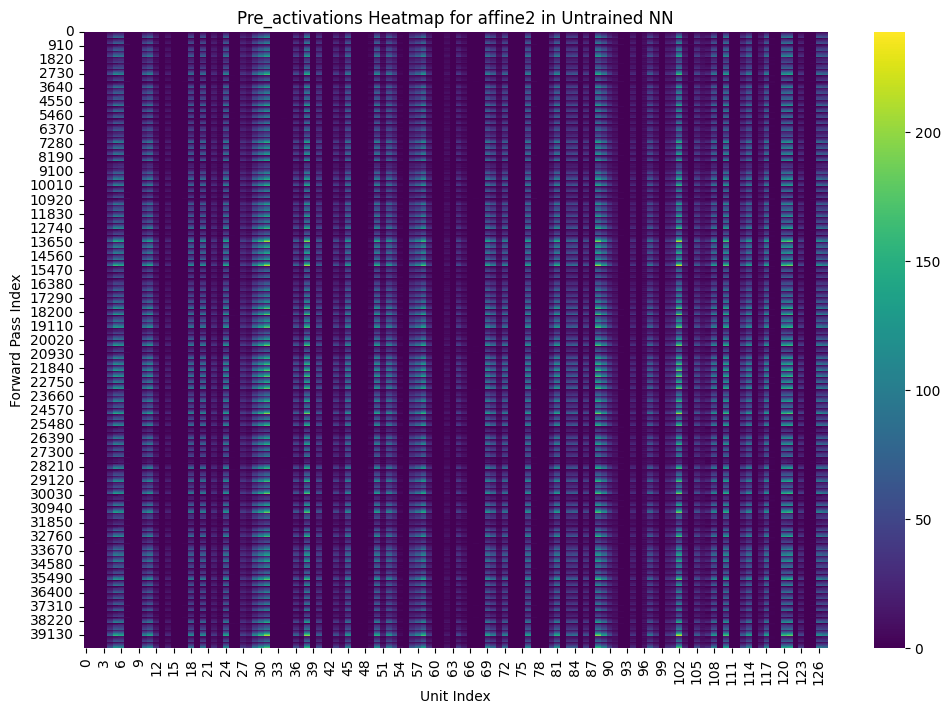

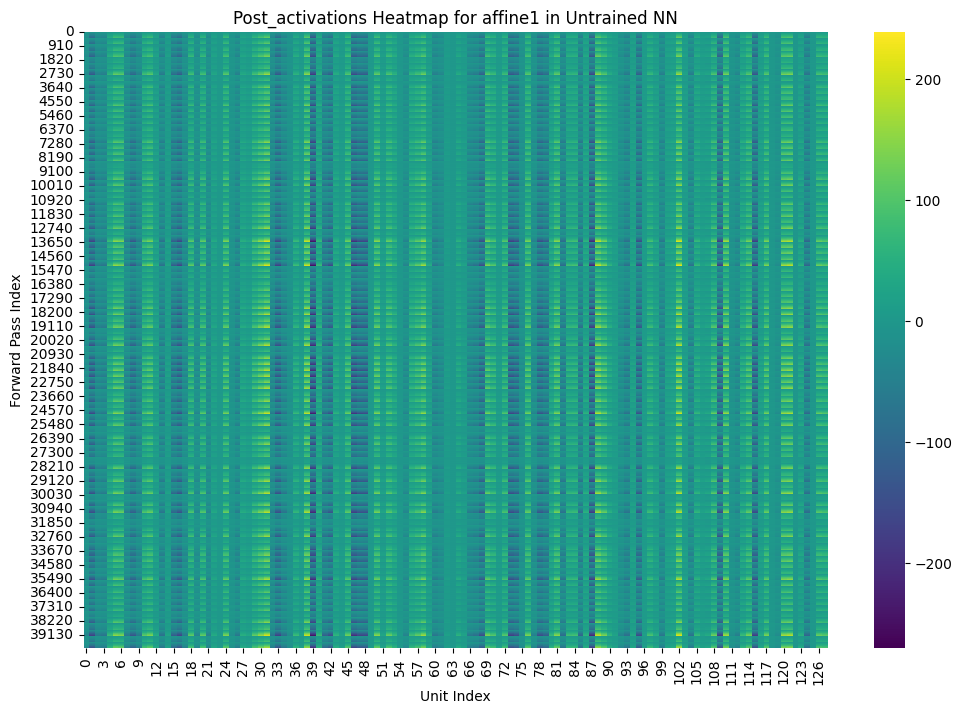

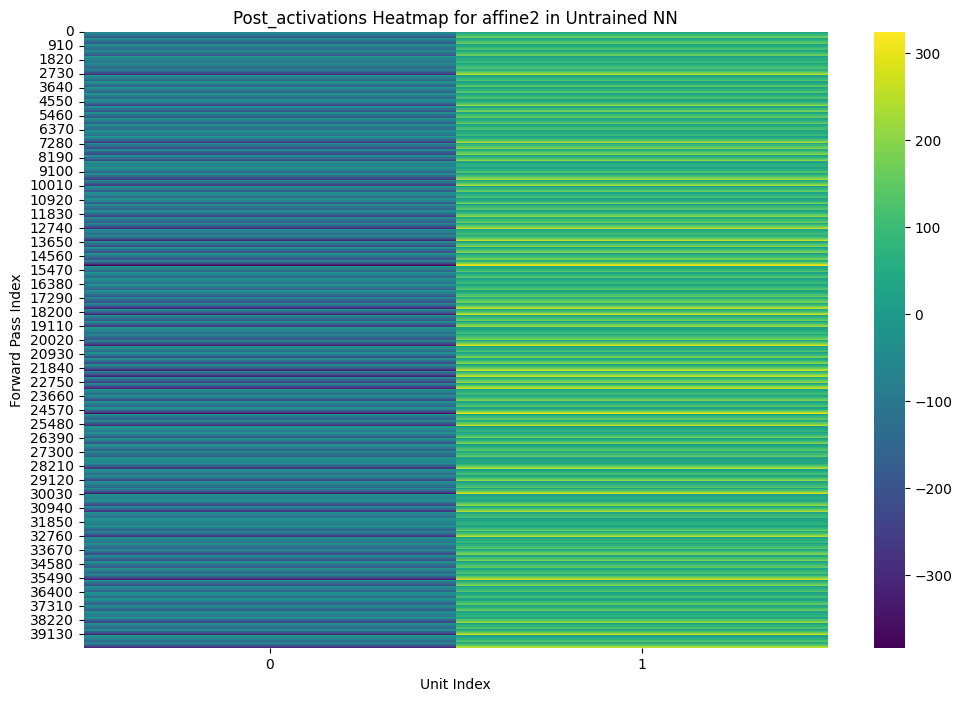

In [ ]:
import seaborn as sns

def plot_activation_heatmap(activation_data, activation_type="pre_activations", nntype='Trained'):
    for layer_name, activations in activation_data[activation_type].items():
        # Convert activations to numpy array
        activations_np = np.array(activations)  # Shape: (num_passes, batch_size, num_units)

        # Remove batch dimension by squeezing
        activations_np = activations_np.squeeze(axis=1)  # Shape: (num_passes, num_units)

        # Heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(activations_np, cmap="viridis", cbar=True)
        plt.title(f"{activation_type.capitalize()} Heatmap for {layer_name} in {nntype} NN")
        plt.xlabel("Unit Index")
        plt.ylabel("Forward Pass Index")
        plt.show()

# Example: Heatmaps for pre-activations and post-activations
plot_activation_heatmap(activ_trained, "pre_activations", nntype='Trained')
plot_activation_heatmap(activ_trained, "post_activations", nntype='Trained')
plot_activation_heatmap(activ_untrained, "pre_activations", nntype='Untrained')
plot_activation_heatmap(activ_untrained, "post_activations", nntype='Untrained')

In [ ]:
import pandas as pd

def save_activations_to_dataframe(activation_data, activation_type="pre_activations",nntype='Trained'):
    dfs = {}  # Dictionary to store DataFrames for each layer

    for layer_name, activations in activation_data[activation_type].items():
        # Convert activations to numpy array
        activations_np = np.array(activations)  # Shape: (num_passes, batch_size, num_units)

        # Remove batch dimension by squeezing
        activations_np = activations_np.squeeze(axis=1)  # Shape: (num_passes, num_units)

        # Create a DataFrame
        df = pd.DataFrame(
            activations_np,
            columns=[f"Unit_{i}" for i in range(activations_np.shape[1])]
        )
        df["Forward_Pass_Index"] = range(activations_np.shape[0])  # Add index for forward passes

        # Store DataFrame for this layer
        dfs[layer_name] = df

        # Save DataFrame as CSV (optional)
        df.to_csv(f"activations2_{activation_type}_{layer_name}_{nntype}NN.csv", index=False)
        print(f"Saved {activation_type} activations for layer {layer_name} to {activation_type}_{layer_name}_activations.csv")

    return dfs

# Save pre-activations and post-activations
trained_pre_activation_dfs = save_activations_to_dataframe(activ_trained, "pre_activations",nntype='Trained')
trained_post_activation_dfs = save_activations_to_dataframe(activ_trained, "post_activations",nntype='Trained')

untrained_pre_activation_dfs = save_activations_to_dataframe(activ_untrained, "pre_activations",nntype='Untrained')
untrained_post_activation_dfs = save_activations_to_dataframe(activ_untrained, "post_activations",nntype='Untrained')

'trained_pre_activation_dfs = save_activations_to_dataframe(activ_trained, "pre_activations",nntype=\'Trained\')\ntrained_post_activation_dfs = save_activations_to_dataframe(activ_trained, "post_activations",nntype=\'Trained\')\n\nuntrained_pre_activation_dfs = save_activations_to_dataframe(activ_untrained, "pre_activations",nntype=\'Untrained\')\nuntrained_post_activation_dfs = save_activations_to_dataframe(activ_untrained, "post_activations",nntype=\'Untrained\')'

In [ ]:

!mv   /content/activation*.csv /content/drive/MyDrive/Models/folder/test_NN_NovelvsNormal/


In [ ]:
# Import necessary libraries
import gymnasium as gym
from enum import Enum
import random
import numpy as np
from scipy.stats import norm

from os import truncate

# Enum defining possible actions the agent can take in the environment: LEFT or RIGHT
class AgentAction(Enum):
    LEFT = 0
    RIGHT = 1

    # Method to get the integer value of the action (0 or 1)
    def get_value(self):
        return self.value

# Enum defining various grid tiles in the environment (e.g., agent, green spaceship, blue spaceship, aliens)
class GridTile(Enum):
    Agent = 0
    Green_Spaceship = 1
    Blue_Spaceship = 2
    R_1_Alien = 3
    R_2_Alien = 4
    P_1_Alien = 5
    P_2_Alien = 6

    # Method to return the first 3 letters of the tile name for printing
    def __str__(self):
        return self.name[:3]

    # Method to get the integer value associated with the grid tile
    def get_value(self):
        return self.value

# Class representing the Two-Step Task environment
class Two_Step_Task:

    # Initialize the environment with grid size and frame rate per second (fps)
    def __init__(self, grid_rows=3, grid_cols=3, fps=1):
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.reset()

    # Reset the environment to its initial state
    def reset(self, seed=None):
        random.seed(seed)  # Set the seed for reproducibility
        self.state = [1, 0, 0]  # Initial state (one-hot encoding)
        self.assign_stimulus()  # Assign stimulus for the left and right actions

        # Positions for rendering the agent and the stimuli
        self.left_stim_pos = [0, 0]
        self.right_stim_pos = [0, 2]
        self.agent_pos = [2, 1]

        self.generate_rewards()  # Generate reward probabilities for each action
        self.trial_num = 1  # Initialize trial number
        self.common = False  # Flag for common stimulus
        self.winning_prob_matrix = []  # Reward probabilities matrix
        self.stake = 1  # Initial stake
        self.score = 0  # Initial score

    # Reset for a new trial
    def reset_trial(self):
        self.state = [1, 0, 0]  # Reset state to initial state
        self.assign_stimulus()  # Re-assign stimuli
        self.left_stim_pos = [0, 0]
        self.right_stim_pos = [0, 2]
        self.agent_pos = [2, 1]
        self.common = False  # Reset common flag

    # Generate reward probabilities for each trial based on Gaussian noise
    def generate_rewards(self):
        self.bounds = [0, 1]  # Set reward bounds
        self.sd = 0.025  # Standard deviation for noise
        self.choices = 2  # Number of possible choices (left or right)
        self.nrtrials = 200  # Number of trials

        # Ensure the bounds are sorted
        self.bounds = np.sort(self.bounds)

        # Initialize rewards matrix
        self.rewards = np.zeros((self.nrtrials, 2, self.choices))

        # Randomly generate reward probabilities for the first trial
        if np.random.rand() < 0.5:
            if np.random.rand() < 0.5:
                x = np.array([0.6, 0.4])
            else:
                x = np.array([0.4, 0.6])
            if np.random.rand() < 0.5:
                x = np.array([x, [0.25, 0.75]])
            else:
                x = np.array([x, [0.75, 0.25]])
        else:
            if np.random.rand() < 0.5:
                x = np.array([0.4, 0.6])
            else:
                x = np.array([0.6, 0.4])
            if np.random.rand() < 0.5:
                x = np.array([[0.25, 0.75], x])
            else:
                x = np.array([[0.75, 0.25], x])

        # Set the reward for the first trial
        self.rewards[0, :, :] = x

        # Loop through each trial to update the rewards with Gaussian noise
        for t in range(1, self.nrtrials):
            for s in range(2):  # Two states
                for a in range(self.choices):  # Two actions (left or right)
                    # Update reward with noise and ensure it stays within bounds
                    self.rewards[t, s, a] = self.rewards[t-1, s, a] + norm.rvs(scale=self.sd)
                    self.rewards[t, s, a] = min(self.rewards[t, s, a], max(self.bounds[1] * 2 - self.rewards[t, s, a], self.bounds[0]))
                    self.rewards[t, s, a] = max(self.rewards[t, s, a], min(self.bounds[0] * 2 - self.rewards[t, s, a], self.bounds[1]))

        # Round rewards to 3 decimal places
        self.rewards = np.round(self.rewards, 3)
        return self.rewards

    # Reset the stake randomly (either 1 or 5)
    def reset_stake(self):
        p = random.random()
        if p <= 0.5:
            self.stake = 1
        else:
            self.stake = 5

    # Assign a stimulus (Green_Spaceship or Blue_Spaceship) to the agent's environment
    def assign_stimulus(self, stim_1=GridTile.Green_Spaceship, stim_2=GridTile.Blue_Spaceship):
        p = random.random()
        if p <= 0.5:
            self.left_stim = stim_1
            self.right_stim = stim_2
        else:
            self.left_stim = stim_2
            self.right_stim = stim_1
        self.state_part2 = [self.left_stim.get_value(), self.right_stim.get_value()]

    # Assign a planet based on the spaceship type (Green or Blue)
    def assign_planet(self, space_ship: GridTile):
        p = random.random()
        if space_ship == GridTile.Green_Spaceship:
            if p <= 0.7:
                self.state = [0, 1, 0]  # Red planet
                self.assign_stimulus(GridTile.R_1_Alien, GridTile.R_2_Alien)
                self.common = True
            else:
                self.state = [0, 0, 1]  # Purple planet
                self.assign_stimulus(GridTile.P_1_Alien, GridTile.P_2_Alien)
                self.common = False
        elif space_ship == GridTile.Blue_Spaceship:
            if p <= 0.7:
                self.state = [0, 0, 1]  # Purple planet
                self.assign_stimulus(GridTile.P_1_Alien, GridTile.P_2_Alien)
                self.common = True
            else:
                self.state = [0, 1, 0]  # Red planet
                self.assign_stimulus(GridTile.R_1_Alien, GridTile.R_2_Alien)
                self.common = False

    # Perform the action (left or right) and return whether the trial is finished
    def perform_action(self, agent_action: AgentAction) -> bool:
        done = False

        if self.state[0]:  # If it's stage 1
            if agent_action == AgentAction.LEFT:
                self.assign_planet(self.left_stim)
            if agent_action == AgentAction.RIGHT:
                self.assign_planet(self.right_stim)
        else:  # It's stage 2
            done = True
            reward_ind_state = self.state.index(1) - 1
            reward_ind_action = agent_action.get_value()
            self.reward_prob = self.rewards[self.trial_num - 1, reward_ind_state, reward_ind_action]
            self.winning_prob_matrix = self.rewards[self.trial_num - 1, :, :]
            if self.trial_num <= 199:
                self.trial_num += 1
            else:
                return done

        return done

    # Render the environment's current state
    def render(self):
        for r in range(self.grid_rows):
            for c in range(self.grid_cols):
                if [r, c] == self.agent_pos:
                    print(GridTile.Agent, end=' ')
                elif [r, c] == self.left_stim_pos:
                    print(GridTile(self.left_stim), end=' ')
                elif [r, c] == self.right_stim_pos:
                    print(GridTile(self.right_stim), end=' ')
                else:
                    print(' ', end=' ')
            print()
        print()

# Custom environment definition for Gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.utils.env_checker import check_env
import numpy as np

# Implement a custom Gym environment, inheriting from gym.Env
class TwoStepTaskEnv(gym.Env):
    metadata = {"render_modes": ["human"], 'render_fps': 1}  # Required metadata

    # Initialize the environment
    def __init__(self, grid_rows=3, grid_cols=3, render_mode=None):
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.render_mode = render_mode

        # Initialize the Two_Step_Task instance
        self.task_agent = Two_Step_Task(grid_rows=grid_rows, grid_cols=grid_cols, fps=self.metadata['render_fps'])

        # Define action and observation space
        self.action_space = spaces.Discrete(len(AgentAction))
        self.observation_space = spaces.Box(
            low=0,
            high=600,
            shape=(7,),
            dtype=np.int64
        )

    # Reset the environment and return the initial observation
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure the environment can be reproduced
        self.task_agent.reset(seed=seed)
        observation = self.task_agent.state + self.task_agent.state_part2 + [self.task_agent.stake] + [self.task_agent.score]
        obs = np.array([observation], dtype=np.int64).reshape((7,))
        info = {}  # Optional additional information

        # Render if necessary
        if self.render_mode == 'human':
            self.render()

        return obs, info

    # Render the environment's current state
    def render(self):
        self.task_agent.render()

    # Step function to perform an action and return the new state, reward, etc.
    def step(self, action):
        end_of_trial = self.task_agent.perform_action(AgentAction(action))

        # Calculate reward and termination status
        reward = 0
        terminated = False
        if end_of_trial:
            reward = int(bool(np.random.rand() < self.task_agent.reward_prob)) * self.task_agent.stake
            self.task_agent.score += reward
            self.task_agent.reset_stake()
            self.task_agent.reset_trial()

        if self.task_agent.trial_num >= 200:
            terminated = True

        observation = self.task_agent.state + self.task_agent.state_part2 + [self.task_agent.stake] + [self.task_agent.score]
        obs = np.array([observation], dtype=np.int64).reshape((7,))

        # Info dictionary with additional trial info
        info = {'number of trials': self.task_agent.trial_num,
                'common': self.task_agent.common,
                'winning_matrix': self.task_agent.winning_prob_matrix,
                'stake': self.task_agent.stake}

        if self.render_mode == 'human':
            print(AgentAction(action))
            self.render()

        return obs, reward, terminated, False, info

# Register the environment with Gym so it can be used in gym.make()
register(
      id='two-step-task-original-v0',  # ID for the environment
      entry_point=TwoStepTaskEnv,  # The class to be used for the environment
)
